# Selección de cripto activos para una cartera de inversión

![picture](https://drive.google.com/uc?export=view&id=1ihM3JEKP-XPaoX9b5bwymu_IF4ntTlz-)

# Trabajo Práctico 4 - Aprendizaje No Supervisado

# Introducción

En finanzas, encontrar grupos de activos similares o regímenes en el comportamiento de los precios es de mucha utilidad, y es de gran ayuda en el desarrollo de filtros, definición de reglas de compra/venta, etc. 

En este práctico aplicaremos métodos de aprendizaje no supervisado. Estas metodologías en muchos casos son aplicadas antes de las de aprendizaje supervisado, dado que frecuentemente nos permiten obtener información útil de nuestros datos.

Podemos destacar métodos como clustering y reducción de dimensionalidad. Algunas de las metodologías despliegan su máximo potencial cuando se dispone de grandes cantidades de datos (activos en nuestro caso).

# 📖 ¡Actividades!

Analizaremos las variaciones (tasas de cambio) de los activos en ventanas específicas de tiempo. Nuestro objetivo será encontrar activos con comportamiento similiar en término de sus retornos.

Para esta actividad seleccionen periodos en los cuales esté disponible la data de todos los activos. 

## Parte I 

Una forma sencilla de predecir el comportamiento de los activos sería suponer que todos siguen el mismo modelo de aprendizaje automático y crear este modelo global para predecir los rendimientos de todos los activos. Sin embargo, es posible que ellos reaccionen de manera diferente a un conjunto de indicadores técnicos. Una forma de resolver este problema es crear un modelo diferente para grupos de activos que se espera que se comporten de manera similar.

Evaluen los siguientes algoritmos de clusterización. 

- Mean Shift.
- k-means. 
- Clustering Jerárquico 

¿Qué activos forman parte de cada cluster? ¿Encuentran alguna relación dentro de cada grupo?

## Parte II 

- Usar la medida de distancia dynamic time warping para agrupar por k-means y comparar con lo obtenido con la métrica euclídea ([link](https://towardsdatascience.com/how-to-apply-k-means-clustering-to-time-series-data-28d04a8f7da3)). Comente los resultados.

## Opcional 

- Aplicar factores dinámicos para ver si las tasas de retorno se pueden resumir en uno o unos pocos constructos subyacentes ([link](https://www.statsmodels.org/stable/examples/notebooks/generated/statespace_dfm_coincident.html))

# Fecha de entrega

- __Versión preliminar: 12/9__ 

# Condiciones de entrega

Realizar un informe en el cual se presenten los resultados y conclusiones del análisis desarrollado. El mismo debe estar pensado para un público técnico pero que desconoce los aspectos propios del problema a resolver. Dicho informe puede ser un notebook, a condición de que en el mismo se efectúe un análisis escrito suficientemente detallado de los resultados. 

# Resolución

## Inicialización

### Importar librerías

In [54]:
import pandas as pd
from sklearn.cluster import MeanShift
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import numpy as np
from tslearn.metrics import dtw
from tslearn.clustering import TimeSeriesKMeans

### Cargar datasets

In [55]:
pairs = ["AAVEUSDT", "ADAUSDT", "AXSUSDT", "BCHUSDT", "BNBUSDT", "BTCUSDT", "COMPUSDT", "DASHUSDT", 
          "DOGEUSDT", "DOTUSDT", "EOSUSDT", "ETCUSDT", "ETHUSDT", "LINKUSDT", "LTCUSDT", "LUNAUSDT", "NEOUSDT", "XMRUSDT", "XRPUSDT"]
interesting_pairs = ["BTCUSDT", "ETHUSDT", "ADAUSDT"]

def add_pair_to_dictionary(dictionary, pair):
  dictionary[pair] = pd.read_csv(f"https://raw.githubusercontent.com/joaquinvvelaco/diplo-datos-2022/main/mentoria/entregables/ayc/output/{pair}_features.csv", index_col=0, parse_dates=True, dayfirst= True)

def get_dataframes():
  dataframes = dict()
  
  for pair in pairs:
    add_pair_to_dictionary(dataframes, pair)
    
  return dataframes

raw_dataframes = get_dataframes() # No agregar columnas en estos dataframes. La idea es mantener los dataframes originales.
dataframes = raw_dataframes.copy() # Cualquier modificación de algún dataframe, realizarlo en estos.
sample_dataframe = dataframes["BTCUSDT"]

### Funciones
Definimos un conjunto de funciones comunes para todos los ejercicios.

#### Funciones compuestas

In [56]:
def do(func, *args):
  for pair in pairs:
    func(pair, *args)  


def do_interesting(func, *args):
  for pair in interesting_pairs:
    func(pair, *args)

### Preprocesamiento

Unimos los datasets en uno solo e intercambiamos filas por columnas. 
Las features (columnas) serán los valores de las tasas de rendimiento para cada día en un determinado periodo de tiempo
Las observaciones (filas) serán cada uno de las criptomonedas

In [57]:
sample_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7307 entries, 2019-01-01 00:00:00 to 2022-05-05 12:00:00
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   open                  7307 non-null   float64
 1   high                  7307 non-null   float64
 2   low                   7307 non-null   float64
 3   close                 7307 non-null   float64
 4   volume                7307 non-null   float64
 5   exchange_rate_open    7306 non-null   float64
 6   exchange_rate_high    7306 non-null   float64
 7   exchange_rate_low     7306 non-null   float64
 8   exchange_rate_close   7306 non-null   float64
 9   exchange_rate_volume  7306 non-null   float64
 10  moving_average_close  7140 non-null   float64
 11  rsi                   7293 non-null   float64
 12  adx                   7280 non-null   float64
 13  macd                  7274 non-null   float64
 14  macd_signal           7274 non-null 

In [58]:
dataframes["AAVEUSDT"].loc["2020":]["exchange_rate_close"].values


array([        nan, -0.08898452,  0.0522074 , ..., -0.00062972,
       -0.06364209,  0.        ])

In [59]:

def get_transpose_dataframe(column, from_date):
    dataframe_ns = pd.DataFrame()
    for pair in pairs:
        values = dataframes[pair].loc[from_date:][column].values
        data = {f'{column}_{pair}': values}
        new_dataframe = pd.DataFrame(data=data).transpose()
        new_dataframe["pair"] = pair
        dataframe_ns = dataframe_ns.append(new_dataframe, ignore_index = True)
    return dataframe_ns

dataframe_ns = get_transpose_dataframe("exchange_rate_close", "2021-01-01")

C:\Users\Joaquin\AppData\Local\Temp\ipykernel_24200\373023175.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataframe_ns = dataframe_ns.append(new_dataframe, ignore_index = True)
C:\Users\Joaquin\AppData\Local\Temp\ipykernel_24200\373023175.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataframe_ns = dataframe_ns.append(new_dataframe, ignore_index = True)
C:\Users\Joaquin\AppData\Local\Temp\ipykernel_24200\373023175.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataframe_ns = dataframe_ns.append(new_dataframe, ignore_index = True)
C:\Users\Joaquin\AppData\Local\Temp\ipykernel_24200\373023175.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

In [60]:
dataframe_ns


,0,1,2,3,4,5,6,7,8,9,...,2925,2926,2927,2928,2929,2930,2931,2932,2933,pair
0,-0.010628,0.014388,-0.014309,0.006119,0.012702,-0.022759,-0.003974,-0.024727,0.015876,0.006204,...,0.040278,-0.031375,0.066161,0.011635,0.031310,-0.016109,-0.000630,-0.063642,0.0,AAVEUSDT
1,-0.014591,-0.004365,0.014650,-0.044846,0.004008,-0.006102,-0.002525,-0.015532,0.045577,0.021851,...,0.042311,0.009075,0.046791,0.033438,0.003370,-0.034263,0.005913,-0.050138,0.0,ADAUSDT
2,-0.008252,-0.014221,0.077941,-0.013027,0.084511,-0.018821,0.011201,-0.028873,-0.007006,-0.022729,...,0.054652,-0.038701,0.075742,0.059943,0.004189,-0.000596,0.013715,-0.075294,0.0,AXSUSDT
3,-0.016113,-0.001061,-0.001608,-0.026630,0.003279,-0.005595,0.018509,-0.004216,0.028381,0.021437,...,0.016520,-0.008990,0.026867,0.011893,0.015782,-0.014876,0.002013,-0.034159,0.0,BCHUSDT
4,-0.008264,0.031363,-0.018464,-0.013414,-0.000593,-0.010041,0.007920,-0.008471,0.022017,0.003085,...,0.007994,-0.005372,0.025206,0.008781,0.003979,-0.008174,0.021479,-0.040342,0.0,BNBUSDT
5,-0.000695,0.001696,0.003559,-0.008700,0.006522,0.002102,0.013138,-0.000945,0.054228,0.054632,...,0.015273,-0.005376,0.021422,0.001634,0.002306,-0.005633,-0.000901,-0.033018,0.0,BTCUSDT
6,-0.070208,0.004820,0.004449,-0.006090,0.001741,-0.000070,0.015502,-0.029299,0.002468,-0.009145,...,0.033144,-0.025665,0.048918,0.029596,0.012195,-0.018072,0.004382,-0.057592,0.0,COMPUSDT
7,-0.016148,-0.000199,0.007163,-0.090882,-0.038683,-0.008477,0.007524,-0.020932,0.037559,0.003564,...,0.021348,-0.016502,0.043624,0.021436,0.019937,-0.011317,0.001041,-0.043659,0.0,DASHUSDT
8,0.019958,0.002474,0.017606,0.018635,0.077741,0.160229,0.070868,0.048900,0.071682,0.497027,...,0.016154,-0.014383,0.029186,0.007463,0.011111,-0.015385,0.002232,-0.032665,0.0,DOGEUSDT
9,-0.021165,-0.000675,-0.027019,-0.033786,-0.012322,0.028723,-0.008839,0.001831,0.072996,0.051393,...,0.011819,-0.020117,0.046358,0.019620,0.016139,-0.012828,-0.009282,-0.063086,0.0,DOTUSDT


In [61]:
numerical_df = dataframe_ns.select_dtypes(include=['float64'])

In [62]:
dataframe_ns_clean = dataframe_ns.copy()

## Parte 1

### Mean Shift

In [63]:
mean_shift = MeanShift().fit(numerical_df)
dataframe_ns["mean_shift_cluster"] = mean_shift.labels_

### KMeans

In [103]:
k_means = KMeans(n_clusters=4).fit(numerical_df)
dataframe_ns["k_means_cluster"] = k_means.labels_

k_means.inertia_

11.31751868159641

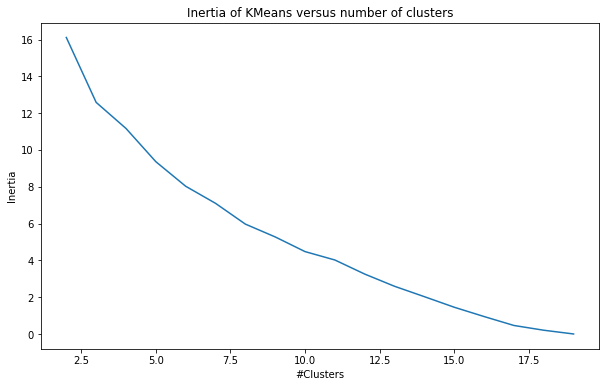

In [65]:
scores = [KMeans(n_clusters=i).fit(numerical_df).inertia_ for i in range(2, 20)]
plt.figure(figsize=(10, 6))
plt.plot(np.arange(2, 20), scores)
plt.xlabel('#Clusters')
plt.ylabel('Inertia')
plt.title('Inertia of KMeans versus number of clusters');

El gráfico del codo indica que no existe una cantidad de clusters óptima dado que la inercia siempre varía al variar la cantidad de clusters, cuando la regla de optimización es encontrar el cambio en el número de clusters que genere un cambio "pequeño" en la inercia. 
Por otro lado, se identifica que el criterio de clustering está muy relacionado a cuan correlacionadas están las series. Por esta razón, cuando se setea la cantidad de clusters = 18, KMeans agrupa a BTC y ETH en el mismo cluster. Este agrupamiento es lógico dada la alta correlación que existen entre ambas series. A su vez, se identifica en el gráfico de codo que de 17 clusters a 18 clusters la variación de la inercia es marginal.

### Jerarquico

In [66]:
agglomerative = AgglomerativeClustering().fit(numerical_df)
dataframe_ns["agglomerative_cluster"] = agglomerative.labels_

In [67]:
dataframe_ns[["pair", "mean_shift_cluster", "k_means_cluster", "agglomerative_cluster"]]

,pair,mean_shift_cluster,k_means_cluster,agglomerative_cluster
0,AAVEUSDT,0,8,0
1,ADAUSDT,0,10,0
2,AXSUSDT,2,0,0
3,BCHUSDT,0,5,0
4,BNBUSDT,0,15,0
5,BTCUSDT,0,1,0
6,COMPUSDT,0,2,0
7,DASHUSDT,0,13,0
8,DOGEUSDT,1,3,1
9,DOTUSDT,0,9,0


Interpretación

## Parte 2

In [69]:
# dtw score BTC vs ETH
dtw(numerical_df[5], numerical_df[12])

0.1104812217209358

In [106]:
# dtw score BTC vs BTC
dtw(numerical_df[12], numerical_df[12])

TypeError: 'TimeSeriesKMeans' object is not callable

En conclusión, el score DTW está condicionado por cuan intensa es la correlación entre dos series de tiempo.
A diferencia de la distancia euclideana es que permite comparar series desfasadas en el tiempo. Sin embargo, esta ventaja práctica no tiene impacto en nuestro análisis dado que todas las series comparten el mismo periodo de tiempo y no existe desfasaje. 

In [70]:
dtw = TimeSeriesKMeans(n_clusters=4, metric="dtw", max_iter=10).fit(numerical_df)
dataframe_ns["dtw_cluster"] = dtw.labels_

In [105]:
dataframe_ns[["pair", "mean_shift_cluster", "k_means_cluster", "agglomerative_cluster", "dtw_cluster"]]

,pair,mean_shift_cluster,k_means_cluster,agglomerative_cluster,dtw_cluster
0,AAVEUSDT,0,2,0,1
1,ADAUSDT,0,2,0,2
2,AXSUSDT,2,1,0,1
3,BCHUSDT,0,0,0,0
4,BNBUSDT,0,2,0,2
5,BTCUSDT,0,2,0,2
6,COMPUSDT,0,2,0,2
7,DASHUSDT,0,0,0,2
8,DOGEUSDT,1,3,1,3
9,DOTUSDT,0,2,0,1
